In [620]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics

%matplotlib inline

import matplotlib.pyplot as plt

In [621]:
# Load + Explore Data


# Set seed to keep the result consistent
np.random.seed(500)

# Load Twitter data
data = pd.read_csv('mental_health_Twitter.csv')

# Count the number of users
len(data['user_id'].value_counts())

# Check the shape of the data
data.shape

# Check for missing values
data.isnull().sum()

# Descriptive Statistics
#data.describe()

data

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain has other ideas...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety,1013187241,84,211,251,837,1,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,819336825231773698,Thu Jan 12 00:14:56 +0000 2017,A day without sunshine is like night.,1169875706,442,230,7,1063601,0,0
19996,19996,819334654260080640,Thu Jan 12 00:06:18 +0000 2017,"Boren's Laws: (1) When in charge, ponder. (2) When in trouble, delegate. (3) When in doubt, mumble.",1169875706,442,230,7,1063601,0,0
19997,19997,819334503042871297,Thu Jan 12 00:05:42 +0000 2017,"The flow chart is a most thoroughly oversold piece of program documentation. ― Frederick Brooks, Jr., The Mythical Man Month",1169875706,442,230,7,1063601,0,0
19998,19998,819334419374899200,Thu Jan 12 00:05:22 +0000 2017,"Ships are safe in harbor, but they were never meant to stay there.",1169875706,442,230,7,1063601,0,0


In [622]:
# Clean Data


# Drop uneccessary columns and keep the ones needed
data = data[['post_text', 'followers', 'favourites', 'retweets', 'label']]
data.head()

# Change dates from string to datetime object
#data['post_created'] = pd.to_datetime(data['post_created'])
#data.head()

# Change the text into lowercase to keep it consistent
data['post_text'] = [x.lower() for x in data['post_text']]
data.head()

# Change 't to "not" to capture the negative word
data['post_text'] = data['post_text'].str.replace("\'t", " not")

# Remove uneccessary characters from the text
# numbers
data['post_text'] = data['post_text'].str.replace("\d","")
# punctuations: apostrophes 
data['post_text'] = data['post_text'].str.replace("[^\w\s]","")
# punctuations: other special components
data['post_text'] = data['post_text'].str.replace("([\;\:\|•«\n])","")
# @ mentions and # hashtags
data['post_text'] = data['post_text'].str.replace("(@.*?)[\s]","")
data['post_text'] = data['post_text'].str.replace("(#.*?)[\s]","")


# Remove stop words
stop = stopwords.words("english")
data["post_text"] = data["post_text"].apply(lambda x: " ".join([x for x in x.split() if x not in stop or x in ['not', 'can']]))

data


/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/1688054355.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_text'] = [x.lower() for x in data['post_text']]
/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/1688054355.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_text'] = data['post_text'].str.replace("\'t", " not")
/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/1688054355.py:21: FutureWarning: The default value of regex will 

,post_text,followers,favourites,retweets,label
0,years since diagnosed anxiety depression today im taking moment reflect far ive come since,84,251,0,1
1,sunday need break im planning spend little time possible,84,251,1,1
2,awake tired need sleep brain ideas,84,251,0,1
3,rt sewhq retro bears make perfect gifts great beginners get stitching octobers sew sale yay httptco,84,251,2,1
4,hard say whether packing lists making life easier reinforcing much still needs movinghouse anxiety,84,251,1,1
...,...,...,...,...,...
19995,day without sunshine like night,442,7,0,0
19996,borens laws charge ponder trouble delegate doubt mumble,442,7,0,0
19997,flow chart thoroughly oversold piece program documentation frederick brooks jr mythical man month,442,7,0,0
19998,ships safe harbor never meant stay,442,7,0,0


In [623]:
# Lemmatization
lemma=nltk.WordNetLemmatizer()

text_list=[]

# Data Cleaning
for text in data['post_text']:
    # Split data into tokens
    description=nltk.word_tokenize(text) 
    # Lemmatize
    lem=[lemma.lemmatize(word) for word in text] 
    # Join with the cleaned words
    lem="".join(lem) 
    text_list.append(lem) 

#text_list

# Vectorization: TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
# Fit vectorizer
vec=vectorizer.fit_transform(text_list)
# Extract words
feature_names = vectorizer.get_feature_names()
x=vec
y=data['label'].values
# Change sparse matrix into the dataframe
dense = x.todense()
den_list = dense.tolist()
df = pd.DataFrame(den_list, columns=feature_names)


# Train-Test Split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)


# Shape checks
vec.shape
#y.shape

/Users/song/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(20000, 10000)

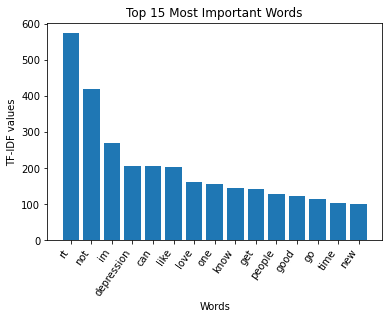

In [624]:
# Visualization

# Get a Transpose of matrix for frequency 
freq = df.T.sum(axis=1).to_frame()
freq = freq.sort_values(by=0,ascending=False)
freq.reset_index(inplace=True)
r = freq.to_numpy()

# Plot Bar graph of Top 15 Most Important Words
plt.bar(r[:15,0], r[:15,1], align='center', alpha=1)
plt.xticks(np.arange(15),  ha='right', rotation=55, fontsize=10)
plt.xlabel('Words')
plt.ylabel('TF-IDF values')
plt.title('Top 15 Most Important Words')
plt.show()

In [625]:
freq



,index,0
0,rt,574.316279
1,not,418.921047
2,im,270.463272
3,depression,206.258337
4,can,206.015563
...,...,...
9995,murica,0.540962
9996,httpstcohwphxyzrnq,0.532350
9997,surefire,0.509586
9998,pipit,0.399108


SVM Accuracy:  85.7 %
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2983
           1       0.86      0.86      0.86      3017

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



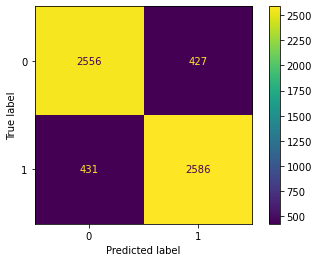

In [626]:
# SVM

# Fit the train data
SVM = svm.SVC(C=1.0, kernel='linear', gamma='auto')
SVM.fit(x_train,y_train)
# Predict the labels on test data
pred = SVM.predict(x_test)

# Get Accuracy & Evaluation Metrics
print("SVM Accuracy: ",accuracy_score(pred, y_test)*100, "%")
print(metrics.classification_report(y_test, pred))

# Confusion Matrix
cm = confusion_matrix(y_test, pred)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM.classes_)
dis.plot()

#print(x_test.shape)

Naive Bayes Accuracy:  86.75 %
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2983
           1       0.86      0.88      0.87      3017

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



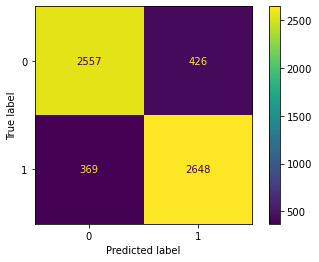

In [627]:
# Naive Bayes

# Fit the train data
NB = naive_bayes.MultinomialNB(alpha = 0.1)
NB.fit(x_train,y_train)
# Predict the labels on test data
pred2 = NB.predict(x_test)

# Get Accuracy & Evaluation Metrics
print("Naive Bayes Accuracy: ",accuracy_score(pred2, y_test)*100, "%")
print(metrics.classification_report(y_test, pred2))

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm2 = confusion_matrix(y_test, pred2)
dis2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=NB.classes_)
dis2.plot()

In [628]:
# Code Not Used ------ Sentiment Analysis 

# Applying sentiment to entire dataset
data["polarity"] = data["post_text"].apply(lambda x: TextBlob(x).sentiment[0])

data["sentiment"] = np.where(data["polarity"] >= 0 , "Positive", "Negative")
data["sentiment_label"] = np.where(data["sentiment"] == "Positive", 0 , 1)
data

/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/3446043808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["polarity"] = data["post_text"].apply(lambda x: TextBlob(x).sentiment[0])
/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/3446043808.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"] = np.where(data["polarity"] >= 0 , "Positive", "Negative")
/var/folders/41/92c5n2ms67jgmdqfz2crw3fw0000gn/T/ipykernel_21965/3446043808.py:7: SettingWithCopyWar

,post_text,followers,favourites,retweets,label,polarity,sentiment,sentiment_label
0,years since diagnosed anxiety depression today im taking moment reflect far ive come since,84,251,0,1,0.100000,Positive,0
1,sunday need break im planning spend little time possible,84,251,1,1,-0.093750,Negative,1
2,awake tired need sleep brain ideas,84,251,0,1,-0.400000,Negative,1
3,rt sewhq retro bears make perfect gifts great beginners get stitching octobers sew sale yay httptco,84,251,2,1,0.900000,Positive,0
4,hard say whether packing lists making life easier reinforcing much still needs movinghouse anxiety,84,251,1,1,-0.045833,Negative,1
...,...,...,...,...,...,...,...,...
19995,day without sunshine like night,442,7,0,0,0.000000,Positive,0
19996,borens laws charge ponder trouble delegate doubt mumble,442,7,0,0,-0.200000,Negative,1
19997,flow chart thoroughly oversold piece program documentation frederick brooks jr mythical man month,442,7,0,0,0.000000,Positive,0
19998,ships safe harbor never meant stay,442,7,0,0,0.500000,Positive,0


In [629]:
data["sentiment"].value_counts()

Positive    16416
Negative     3584
Name: sentiment, dtype: int64

In [630]:
# Train-test Split before applying Model
x = data['post_text']
y = data['label']

train_x, test_x, train_y, test_y = model_selection.train_test_split(x,y,test_size=0.3)


In [43]:
# Split DataFrame based on column value condition
data2 = data[data['label'] == 1]
pd.set_option('display.max_colwidth', None)
len(data2['user_id'].value_counts())

54